
<div class="alert alert-info">

**This is a fixed-text formatted version of a Jupyter notebook**

- Try online [![Binder](https://static.mybinder.org/badge.svg)](https://mybinder.org/v2/gh/gammapy/gammapy-webpage/master?urlpath=lab/tree/analysis_mwl.ipynb)
- You can contribute with your own notebooks in this
[GitHub repository](https://github.com/gammapy/gammapy/tree/master/docs/tutorials).
- **Source files:**
[analysis_mwl.ipynb](../_static/notebooks/analysis_mwl.ipynb) |
[analysis_mwl.py](../_static/notebooks/analysis_mwl.py)
</div>


# Joint modeling, fitting, and serialization


## Prerequisites

- Handling of Fermi-LAT data with gammapy [see the corresponding tutorial](fermi_lat.ipynb)
- Knowledge of spectral analysis to produce 1D On-Off datasets, [see the following tutorial](spectrum_analysis.ipynb)
- Using flux points to directly fit a model (without forward-folding)  [see the SED fitting tutorial](sed_fitting.ipynb)

## Context

Some science studies require to combine heterogeneous data from various instruments to extract physical informations. In particular, it is often useful to add flux measurements of a source at different energies to an analysis to better constrain the wide-band spectral parameters. This can be done using a joint fit of heterogeneous datasets.
 
**Objectives: Constrain the spectral parameters of the gamma-ray emission from the Crab nebula between 10 GeV and 100 TeV, using a 3D Fermi dataset, a H.E.S.S. reduced spectrum and HAWC flux points.**

## Proposed approach

This tutorial illustrates how to perfom a joint modeling and fitting of the Crab Nebula spectrum using different datasets.
The spectral parameters are optimized by combining a 3D analysis of Fermi-LAT data, a ON/OFF spectral analysis of HESS data, and flux points from HAWC.

In this tutorial we are going to use pre-made datasets. We prepared maps of the Crab region as seen by Fermi-LAT using the same event selection than the [3FHL catalog](https://arxiv.org/abs/1702.00664) (7 years of data with energy from 10 GeV to 2 TeV). For the HESS ON/OFF analysis we used two observations from the [first public data release](https://arxiv.org/abs/1810.04516) with a significant signal from energy of about 600 GeV to 10 TeV. These observations have an offset of 0.5° and a zenith angle of 45-48°. The HAWC flux points data are taken from a [recent analysis](https://arxiv.org/pdf/1905.12518.pdf) based on 2.5 years of data with energy between 300 Gev and 300 TeV. 

## The setup


In [1]:
from astropy import units as u
import matplotlib.pyplot as plt
from gammapy.modeling import Fit
from gammapy.datasets import Datasets, FluxPointsDataset, SpectrumDatasetOnOff
from gammapy.estimators import FluxPoints, FluxPointsEstimator
from gammapy.maps import MapAxis
from pathlib import Path

## Data and models files


The datasets serialization produce YAML files listing the datasets and models. In the following cells we show an example containning only the Fermi-LAT dataset and the Crab model. 

Fermi-LAT-3FHL_datasets.yaml:

```yaml
datasets:
- name: Fermi-LAT
  type: MapDataset
  likelihood: cash
  models:
- Crab Nebula
  background: background
  filename: $GAMMAPY_DATA/fermi-3fhl-crab/Fermi-LAT-3FHL_data_Fermi-LAT.fits
```

We used as model a point source with a log-parabola spectrum. The initial parameters were taken from the latest Fermi-LAT catalog [4FGL](https://arxiv.org/abs/1902.10045), then we have re-optimized the spectral parameters for our dataset in the 10 GeV - 2 TeV energy range (fixing the source position).

Fermi-LAT-3FHL_models.yaml:

```yaml
components:
- name: Crab Nebula
  type: SkyModel
  spatial:
    type: PointSpatialModel
    frame: icrs
    parameters:
    - name: lon_0
      value: 83.63310241699219
      unit: deg
      min: .nan
      max: .nan
      frozen: true
    - name: lat_0
      value: 22.019899368286133
      unit: deg
      min: -90.0
      max: 90.0
      frozen: true
  spectral:
    type: LogParabolaSpectralModel
    parameters:
    - name: amplitude
      value: 0.3415498620816483
      unit: cm-2 s-1 TeV-1
      min: .nan
      max: .nan
      frozen: false
    - name: reference
      value: 5.054833602905273e-05
      unit: TeV
      min: .nan
      max: .nan
      frozen: true
    - name: alpha
      value: 2.510798031388936
      unit: ''
      min: .nan
      max: .nan
      frozen: false
    - name: beta
      value: -0.022476498188855533
      unit: ''
      min: .nan
      max: .nan
      frozen: false
- name: background
  type: BackgroundModel
  parameters:
  - name: norm
    value: 0.9544383244743555
    unit: ''
    min: 0.0
    max: .nan
    frozen: false
  - name: tilt
    value: 0.0
    unit: ''
    min: .nan
    max: .nan
    frozen: true
  - name: reference
    value: 1.0
    unit: TeV
    min: .nan
    max: .nan
    frozen: true

```

## Reading  different datasets


### Fermi-LAT 3FHL: map dataset for 3D analysis
For now we let's use the datasets serialization only to read the 3D `MapDataset` associated to Fermi-LAT 3FHL data and models.

In [2]:
path = Path("$GAMMAPY_DATA/fermi-3fhl-crab")
filedata = "Fermi-LAT-3FHL_datasets.yaml"
filemodel = "Fermi-LAT-3FHL_models.yaml"
datasets = Datasets.read(path, filedata=filedata, filemodel=filemodel)
dataset_fermi = datasets[0]

In [3]:
print(datasets[0].models)

ProperModels

Component 0: SkyModel

  Name                      : Crab Nebula
  Datasets names            : None
  Spectral model type       : LogParabolaSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    amplitude               :   1.82e-02  1 / (cm2 s TeV)
    reference    (frozen)   :   0.000  TeV         
    alpha                   :   1.652              
    beta                    :   0.039              
    lon_0        (frozen)   :  83.633  deg         
    lat_0        (frozen)   :  22.020  deg         

Component 1: BackgroundModel

  Name                      : iem_v06
  Datasets names            : ['Fermi-LAT']
  Parameters:
    norm                    :   1.300              
    tilt         (frozen)   :   0.000              
    reference    (frozen)   :   1.000  TeV         




We get the Crab model in order to share it with the other datasets

In [4]:
crab_model = dataset_fermi.models["Crab Nebula"]
crab_spec = crab_model.spectral_model
print(crab_spec)

LogParabolaSpectralModel

   name     value        unit      min max frozen   error  
--------- --------- -------------- --- --- ------ ---------
amplitude 1.818e-02 cm-2 s-1 TeV-1 nan nan  False 3.026e-03
reference 5.055e-05            TeV nan nan   True 0.000e+00
    alpha 1.652e+00                nan nan  False 5.763e-02
     beta 3.922e-02                nan nan  False 5.215e-03


### HESS-DL3: 1D ON/OFF dataset for spectral fitting

The ON/OFF datasets can be read from PHA files following the [OGIP standards](https://heasarc.gsfc.nasa.gov/docs/heasarc/ofwg/docs/spectra/ogip_92_007/node5.html).
We read the PHA files from each observation, and compute a stacked dataset for simplicity.
Then the Crab spectral model previously defined is added to the dataset.

In [5]:
datasets = []

for obs_id in [23523, 23526]:
    dataset = SpectrumDatasetOnOff.from_ogip_files(
        f"$GAMMAPY_DATA/joint-crab/spectra/hess/pha_obs{obs_id}.fits"
    )
    datasets.append(dataset)

dataset_hess = Datasets(datasets).stack_reduce(name="HESS")
dataset_hess.models = crab_model

### HAWC: 1D dataset for flux point fitting

The HAWC flux point are taken from https://arxiv.org/pdf/1905.12518.pdf. Then these flux points are read from a pre-made FITS file and passed to a `FluxPointsDataset` together with the source spectral model.


In [6]:
# read flux points from https://arxiv.org/pdf/1905.12518.pdf
filename = "$GAMMAPY_DATA/hawc_crab/HAWC19_flux_points.fits"
flux_points_hawc = FluxPoints.read(filename)
dataset_hawc = FluxPointsDataset(crab_model, flux_points_hawc, name="HAWC")

## Datasets serialization

The `datasets` object contains each dataset previously defined. 
It can be saved on disk as datasets.yaml, models.yaml, and several data files specific to each dataset. Then the `datasets` can be rebuild later from these files.

In [7]:
datasets = Datasets([dataset_fermi, dataset_hess, dataset_hawc])
path = Path("crab-3datasets")
path.mkdir(exist_ok=True)

datasets.write(path=path, prefix="crab_10GeV_100TeV", overwrite=True)
filedata = "crab_10GeV_100TeV_datasets.yaml"
filemodel = "crab_10GeV_100TeV_models.yaml"
datasets = Datasets.read(path, filedata=filedata, filemodel=filemodel)

HDU 'MASK_FIT' not found
/usr/share/miniconda/envs/gammapy-dev/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [8]:
print(datasets)

Datasets
--------

Dataset 0: 

  Type       : MapDataset
  Name       : Fermi-LAT
  Instrument : 

Dataset 1: 

  Type       : SpectrumDatasetOnOff
  Name       : HESS
  Instrument : 

Dataset 2: 

  Type       : FluxPointsDataset
  Name       : HAWC
  Instrument : 




In [9]:
print(datasets["HESS"].models)

ProperModels

Component 0: SkyModel

  Name                      : Crab Nebula
  Datasets names            : None
  Spectral model type       : LogParabolaSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    amplitude               :   1.82e-02  1 / (cm2 s TeV)
    reference               :   0.000  TeV         
    alpha                   :   1.652              
    beta                    :   0.039              
    lon_0        (frozen)   :  83.633  deg         
    lat_0        (frozen)   :  22.020  deg         




## Joint analysis

We run the fit on the `Datasets` object that include a dataset for each instrument


In [10]:
%%time
fit_joint = Fit(datasets)
results_joint = fit_joint.run()
print(results_joint)
print(results_joint.parameters.to_table())

HDU 'MASK_FIT' not found
/usr/share/miniconda/envs/gammapy-dev/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in log
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/usr/share/miniconda/envs/gammapy-dev/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in log
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 500
	total stat : -12696.13

   name     value        unit      min max frozen   error  
--------- --------- -------------- --- --- ------ ---------
amplitude 3.445e-03 cm-2 s-1 TeV-1 nan nan  False 5.637e-04
reference 5.762e-05            TeV nan nan  False 5.831e-07
    alpha 1.279e+00                nan nan  False 3.503e-02
     beta 6.170e-02                nan nan  False 2.060e-03
    lon_0 8.363e+01            deg nan nan   True 0.000e+00
    lat_0 2.202e+01            deg nan nan   True 0.000e+00
     norm 1.305e+00                nan nan  False 7.556e-02
     tilt 0.000e+00                nan nan   True 0.000e+00
reference 1.000e+00            TeV nan nan  False 1.414e+00
CPU times: user 4.83 s, sys: 8.02 ms, total: 4.84 s
Wall time: 4.84 s


Let's display only the parameters of the Crab spectral model

In [11]:
crab_spec = datasets[0].models["Crab Nebula"].spectral_model
print(crab_spec)

LogParabolaSpectralModel

   name     value        unit      min max frozen   error  
--------- --------- -------------- --- --- ------ ---------
amplitude 3.445e-03 cm-2 s-1 TeV-1 nan nan  False 5.637e-04
reference 5.762e-05            TeV nan nan  False 5.831e-07
    alpha 1.279e+00                nan nan  False 3.503e-02
     beta 6.170e-02                nan nan  False 2.060e-03


We can compute flux points for Fermi-LAT and HESS datasets in order plot them together with the HAWC flux point.

In [12]:
dataset_fermi.counts.geom.axes[0]

MapAxis

	name       : energy    
	unit       : 'TeV'     
	nbins      : 5         
	node type  : edges     
	edges min  : 1.0e-02 TeV
	edges max  : 2.0e+00 TeV
	interp     : log       

In [13]:
# compute Fermi-LAT and HESS flux points
e_edges = MapAxis.from_energy_bounds("10 GeV", "2 TeV", nbin=5).edges

flux_points_fermi = FluxPointsEstimator(
    e_edges=e_edges, source="Crab Nebula"
).run([dataset_fermi])


e_edges = MapAxis.from_bounds(1, 15, nbin=6, interp="log", unit="TeV").edges
flux_points_hess = FluxPointsEstimator(
    e_edges=e_edges, source="Crab Nebula"
).run([dataset_hess])

Now, Let's plot the Crab spectrum fitted and the flux points of each instrument.


/home/runner/work/gammapy-docs/gammapy-docs/gammapy/gammapy/modeling/models/spectral.py:357: MatplotlibDeprecationWarning: The 'nonposx' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_xscale("log", nonposx="clip")
/home/runner/work/gammapy-docs/gammapy-docs/gammapy/gammapy/modeling/models/spectral.py:358: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_yscale("log", nonposy="clip")
/home/runner/work/gammapy-docs/gammapy-docs/gammapy/gammapy/estimators/flux_point.py:668: MatplotlibDeprecationWarning: The 'nonposx' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_xscale("log", nonposx="clip")
/home/runner/work/gammapy-docs/gammapy-docs

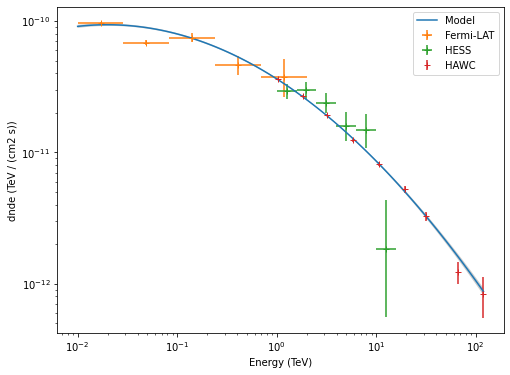

In [14]:
# display spectrum and flux points
energy_range = [0.01, 120] * u.TeV
plt.figure(figsize=(8, 6))
ax = crab_spec.plot(energy_range=energy_range, energy_power=2, label="Model")
crab_spec.plot_error(ax=ax, energy_range=energy_range, energy_power=2)
flux_points_fermi.plot(ax=ax, energy_power=2, label="Fermi-LAT")
flux_points_hess.plot(ax=ax, energy_power=2, label="HESS")
flux_points_hawc.plot(ax=ax, energy_power=2, label="HAWC")
plt.legend();